# **First, a linet to import all libraries**

In [58]:
import os
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing.image as tf_image
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.initializers import RandomNormal
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from collections import Counter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
import pickle
from google.colab import files
from joblib import dump
import shutil
from google.colab import drive



# **Now, I will upload my dataset and resize images**

In [2]:
def load_and_resize_images(images_path, target_size=(256, 256)):
    images = []
    labels = []

    for label in os.listdir(images_path):
        label_path = os.path.join(images_path, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                if os.path.isfile(image_path):
                    image = Image.open(image_path).resize(target_size)
                    images.append(np.array(image))
                    labels.append(label)

    return images, labels


In [4]:
images, labels = load_and_resize_images(images_path= '/content/drive/MyDrive/Ironhack proyect', target_size= (256,256))

# **Created a function to check for class imbalance in my dataset an plot the distribution**

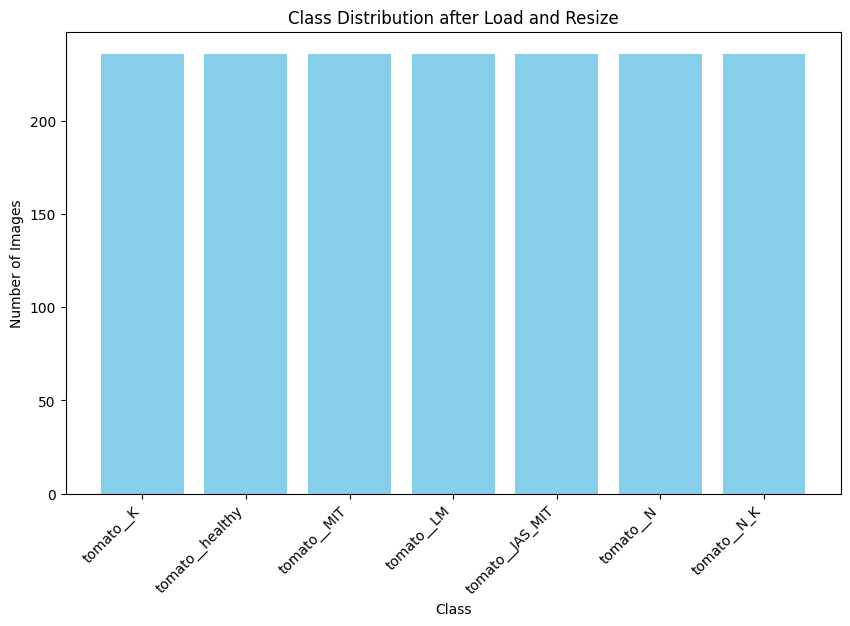

In [49]:
def check_class_distribution(labels):
    class_counts = {}
    for label in labels:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

class_counts = check_class_distribution(labels)


plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution after Load and Resize')
plt.xticks(rotation=45, ha='right')
plt.savefig('original_distribution.png')
plt.show()

# **Now I will apply a new function to address class imbalance using smote**


In [6]:
def apply_smote(images, labels, target_samples=200):

    images = np.array(images)
    labels = np.array(labels)

    num_samples = images.shape[0]
    num_features = np.prod(images.shape[1:])
    images_2d = images.reshape(num_samples, num_features)

    label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
    labels_int = np.array([label_to_int[label] for label in labels])

    smote = SMOTE(sampling_strategy={label_to_int[label]: target_samples for label in label_to_int.keys()}, random_state=42)
    images_resampled_2d, labels_resampled = smote.fit_resample(images_2d, labels_int)

    images_resampled = images_resampled_2d.reshape(-1, *images.shape[1:])

    int_to_label = {i: label for label, i in label_to_int.items()}
    labels_resampled = [int_to_label[i] for i in labels_resampled]

    images_resampled, labels_resampled = shuffle(images_resampled, labels_resampled, random_state=42)

    return images_resampled, labels_resampled

In [7]:
images_resampled, labels_resampled = apply_smote(images, labels, target_samples=236)

# **Now I will check the output**


<ipython-input-51-665f349a3319>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(class_counts_before.keys(), rotation=45, ha='right')
<ipython-input-51-665f349a3319>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(class_counts_after.keys(), rotation=45, ha='right')


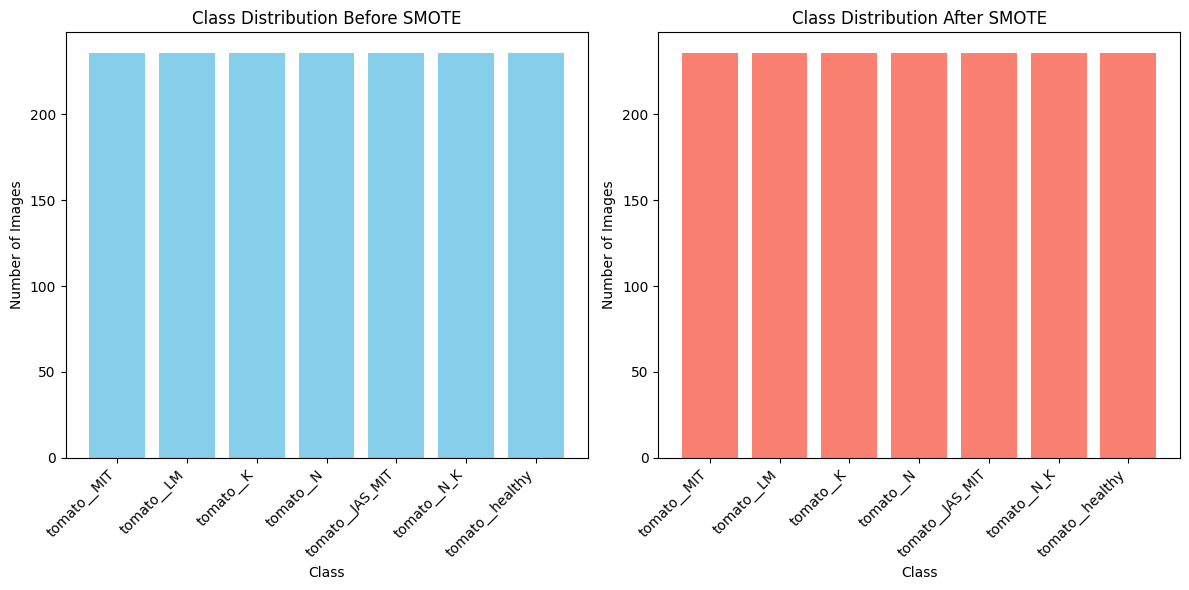

In [51]:

class_counts_before = {label: labels.count(label) for label in set(labels)}

class_counts_after = {label: labels_resampled.count(label) for label in set(labels_resampled)}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.bar(class_counts_before.keys(), class_counts_before.values(), color='skyblue')
ax1.set_title('Class Distribution Before SMOTE')
ax1.set_xlabel('Class')
ax1.set_ylabel('Number of Images')
ax1.set_xticklabels(class_counts_before.keys(), rotation=45, ha='right')

ax2.bar(class_counts_after.keys(), class_counts_after.values(), color='salmon')
ax2.set_title('Class Distribution After SMOTE')
ax2.set_xlabel('Class')
ax2.set_ylabel('Number of Images')
ax2.set_xticklabels(class_counts_after.keys(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# **I will rename the images and labels variables**

In [9]:
images, labels= images_resampled, labels_resampled

# **Checked the new number of total samples**

In [10]:

total_samples = len(images)
print("Total number of samples:", total_samples)
total_labels = len(labels)
print("Total number of labels:", total_labels)


Total number of samples: 1652
Total number of labels: 1652


# **Now I will use a function to turn images into an np.array and to encode the labels**

In [11]:
def preprocess_data(images, labels):

    images_array = np.array(images)

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = labels_encoded.reshape(len(labels_encoded), 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    labels_onehot = onehot_encoder.fit_transform(labels_encoded)

    return images_array, labels_onehot

In [12]:
images_array, labels_encoded= preprocess_data(images, labels)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [93]:
print(labels_encoded)

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


# **I will create a new function to store my label encoder**

In [120]:
def encoder_retriever(labels):
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = labels_encoded.reshape(len(labels_encoded), 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    labels_onehot = onehot_encoder.fit_transform(labels_encoded)
    return label_encoder



In [121]:
label_encoder = encoder_retriever(labels)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

files.download('label_encoder.pkl')

print(label_encoder)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

LabelEncoder()


In [125]:
drive_destination_path = '/content/drive/MyDrive/Ironhack proyect/label_encoder.pkl'
shutil.copy("label_encoder.pkl", drive_destination_path)

'/content/drive/MyDrive/Ironhack proyect/label_encoder.pkl'

# **Now I will do the X/y split**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images_array, labels_encoded, test_size=0.2, random_state=42)
image_width= 256
image_height= 256


# **First Model**

In [14]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Conv2D(128, (3, 3), activation='relu'))
model_1.add(MaxPooling2D((2, 2)))
model_1.add(Flatten())
model_1.add(Dense(512, activation='relu'))
model_1.add(Dense(7, activation='softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("model_1_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_1 = model_1.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

test_loss_1, test_accuracy_1 = model_1.evaluate(X_test, y_test)
print("Test Accuracy for Model 1:", test_accuracy_1)


Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 24.6444 - accuracy: 0.3126
Epoch 1: val_accuracy improved from -inf to 0.42900, saving model to model_1_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 12s 119ms/step - loss: 24.6444 - accuracy: 0.3126 - val_loss: 1.5417 - val_accuracy: 0.4290
Epoch 2/20
41/42 [============================>.] - ETA: 0s - loss: 1.3632 - accuracy: 0.5084
Epoch 2: val_accuracy improved from 0.42900 to 0.46224, saving model to model_1_best.h5
42/42 [==============================] - 3s 72ms/step - loss: 1.3634 - accuracy: 0.5072 - val_loss: 1.4589 - val_accuracy: 0.4622
Epoch 3/20
41/42 [============================>.] - ETA: 0s - loss: 0.9246 - accuracy: 0.6700
Epoch 3: val_accuracy improved from 0.46224 to 0.56495, saving model to model_1_best.h5
42/42 [==============================] - 3s 72ms/step - loss: 0.9275 - accuracy: 0.6684 - val_loss: 1.3807 - val_accuracy: 0.5650
Epoch 4/20
41/42 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.7713
Epoch 4: val_accuracy improved from 0.56495 to 0.59215, saving model to model_1_best.h5
42/42 [==============================] - 3s 69ms/step - loss:

# **Creation of a function to plot the training progress**

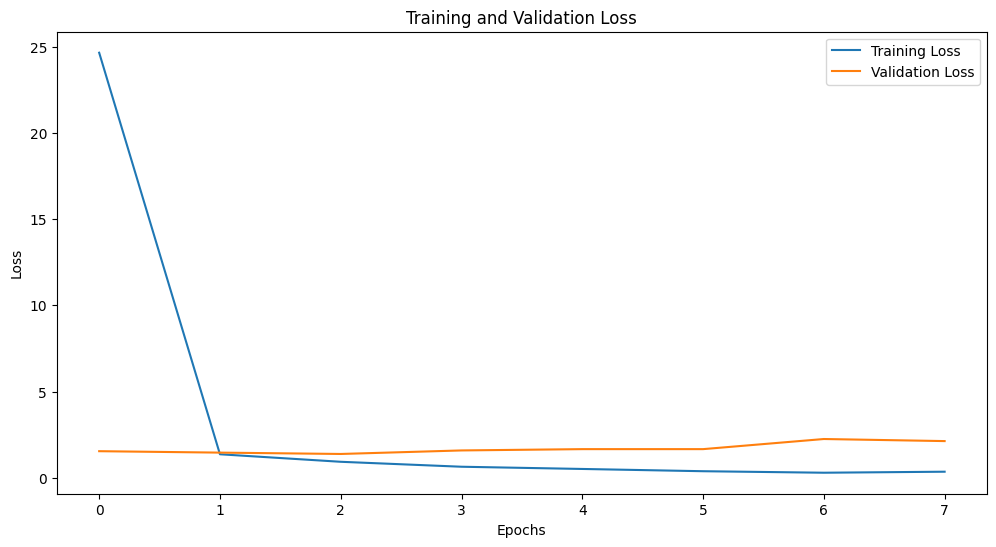

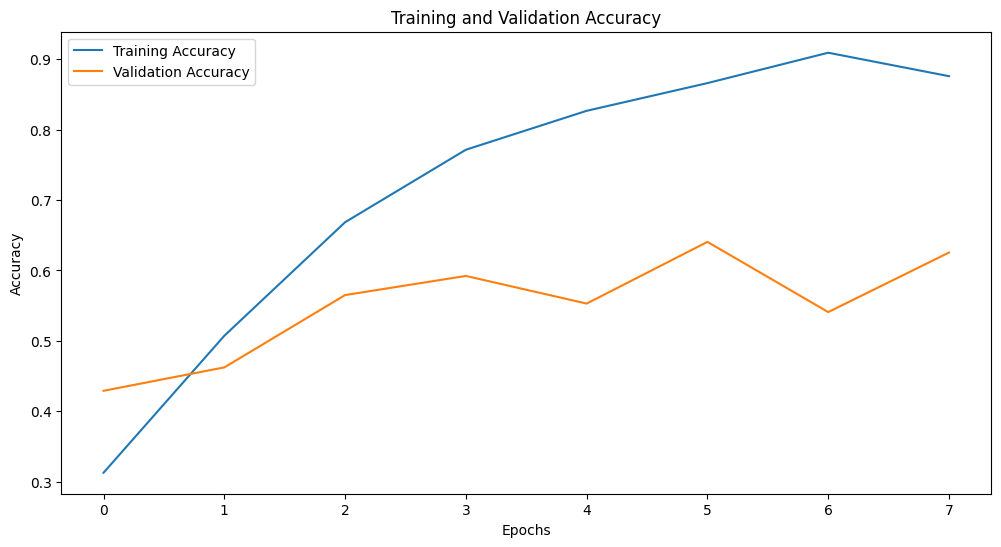

In [15]:
def plot_training_history(history):

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

plot_training_history(history_1)

# **I will plot a confusion matrix**

11/11 [==============================] - 0s 19ms/step


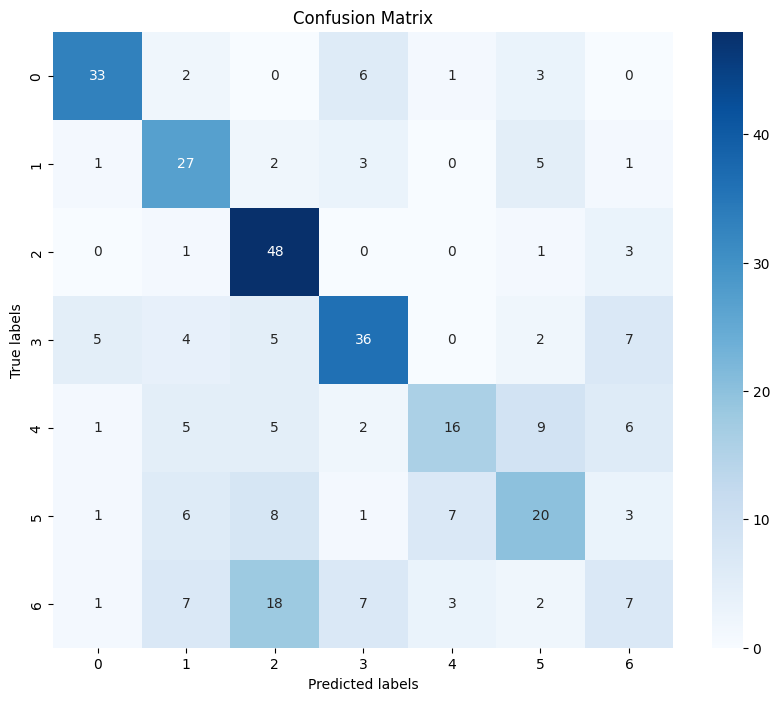

In [16]:
def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)

    label_encoder = LabelEncoder()
    label_encoder.fit(y_test)
    class_labels = label_encoder.inverse_transform(np.unique(y_test))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

pcm1 = plot_confusion_matrix(model_1, X_test, y_test)

In [17]:
print(labels)

['tomato__K', 'tomato__healthy', 'tomato__MIT', 'tomato__LM', 'tomato__healthy', 'tomato__LM', 'tomato__JAS_MIT', 'tomato__JAS_MIT', 'tomato__N', 'tomato__healthy', 'tomato__JAS_MIT', 'tomato__N_K', 'tomato__LM', 'tomato__N_K', 'tomato__K', 'tomato__N_K', 'tomato__K', 'tomato__LM', 'tomato__N', 'tomato__JAS_MIT', 'tomato__K', 'tomato__K', 'tomato__N', 'tomato__K', 'tomato__JAS_MIT', 'tomato__K', 'tomato__JAS_MIT', 'tomato__MIT', 'tomato__JAS_MIT', 'tomato__healthy', 'tomato__K', 'tomato__N', 'tomato__N', 'tomato__N', 'tomato__JAS_MIT', 'tomato__N', 'tomato__N_K', 'tomato__K', 'tomato__LM', 'tomato__healthy', 'tomato__LM', 'tomato__N', 'tomato__healthy', 'tomato__MIT', 'tomato__healthy', 'tomato__healthy', 'tomato__N_K', 'tomato__LM', 'tomato__K', 'tomato__N', 'tomato__N', 'tomato__JAS_MIT', 'tomato__healthy', 'tomato__LM', 'tomato__N', 'tomato__N', 'tomato__JAS_MIT', 'tomato__healthy', 'tomato__LM', 'tomato__LM', 'tomato__MIT', 'tomato__N', 'tomato__N', 'tomato__LM', 'tomato__LM', 'tom

#**Second Model**

In [18]:
model_2 = Sequential()
model_2.add(Conv2D(64, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(128, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Conv2D(256, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))
model_2.add(Flatten())
model_2.add(Dense(512, activation='relu'))
model_2.add(Dense(7, activation='softmax'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_2 = ModelCheckpoint("model_2_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint_2, early_stopping_2])

test_loss_2, test_accuracy_2 = model_2.evaluate(X_test, y_test)
print("Test Accuracy for Model 2:", test_accuracy_2)

Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 154.3022 - accuracy: 0.3838
Epoch 1: val_accuracy improved from -inf to 0.52568, saving model to model_2_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


42/42 [==============================] - 20s 346ms/step - loss: 154.3022 - accuracy: 0.3838 - val_loss: 1.4561 - val_accuracy: 0.5257
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.0133 - accuracy: 0.6525
Epoch 2: val_accuracy did not improve from 0.52568
42/42 [==============================] - 6s 145ms/step - loss: 1.0133 - accuracy: 0.6525 - val_loss: 1.5677 - val_accuracy: 0.4894
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.7176
Epoch 3: val_accuracy improved from 0.52568 to 0.67069, saving model to model_2_best.h5
42/42 [==============================] - 11s 265ms/step - loss: 0.9482 - accuracy: 0.7176 - val_loss: 1.5910 - val_accuracy: 0.6707
Epoch 4/20
42/42 [==============================] - ETA: 0s - loss: 0.4625 - accuracy: 0.8675
Epoch 4: val_accuracy did not improve from 0.67069
42/42 [==============================] - 6s 145ms/step - loss: 0.4625 - accuracy: 0.8675 - val_loss: 1.6054 - val_accuracy: 0.6526


# **Third Model**

In [19]:
model_3 = Sequential()
model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(64, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(128, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Conv2D(256, (3, 3), activation='relu'))
model_3.add(MaxPooling2D((2, 2)))
model_3.add(Flatten())
model_3.add(Dense(512, activation='relu'))
model_3.add(Dense(7, activation='softmax'))

model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_3 = ModelCheckpoint("model_3_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_3 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_3 = model_3.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint_3, early_stopping_3])

test_loss_3, test_accuracy_3 = model_3.evaluate(X_test, y_test)
print("Test Accuracy for Model 3:", test_accuracy_3)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 37.9928 - accuracy: 0.3126
Epoch 1: val_accuracy improved from -inf to 0.43505, saving model to model_3_best.h5
42/42 [==============================] - 6s 100ms/step - loss: 37.9928 - accuracy: 0.3126 - val_loss: 1.7207 - val_accuracy: 0.4350
Epoch 2/100
41/42 [============================>.] - ETA: 0s - loss: 1.3188 - accuracy: 0.5297
Epoch 2: val_accuracy improved from 0.43505 to 0.52870, saving model to model_3_best.h5
42/42 [==============================] - 4s 90ms/step - loss: 1.3149 - accuracy: 0.5299 - val_loss: 1.4708 - val_accuracy: 0.5287
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 0.8269 - accuracy: 0.7066
Epoch 3: val_accuracy improved from 0.52870 to 0.55287, saving model to model_3_best.h5
42/42 [==============================] - 4s 90ms/step - loss: 0.8235 - accuracy: 0.7070 - val_loss: 1.4577 - val_accuracy: 0.5529
Epoch 4/100
41/42 [============================>.] - ETA: 0s 

# **Fourth Model**

In [20]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

for layer in base_model.layers:
    layer.trainable = False

model_4 = Sequential()
model_4.add(base_model)
model_4.add(Flatten())
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(7, activation='softmax'))

model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_4 = ModelCheckpoint("model_4_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_4 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_4 = model_4.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint_4, early_stopping_4])

test_loss_4, test_accuracy_4 = model_4.evaluate(X_test, y_test)
print("Test Accuracy for Model 4:", test_accuracy_4)


58889256/58889256 [==============================] - 3s 0us/step
Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 24.5315 - accuracy: 0.5314
Epoch 1: val_accuracy improved from -inf to 0.66767, saving model to model_4_best.h5
42/42 [==============================] - 27s 433ms/step - loss: 24.5315 - accuracy: 0.5314 - val_loss: 6.0647 - val_accuracy: 0.6677
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 3.3658 - accuracy: 0.7078
Epoch 2: val_accuracy improved from 0.66767 to 0.75227, saving model to model_4_best.h5
42/42 [==============================] - 9s 226ms/step - loss: 3.3658 - accuracy: 0.7078 - val_loss: 1.2740 - val_accuracy: 0.7523
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 1.0198 - accuracy: 0.7933
Epoch 3: val_accuracy improved from 0.75227 to 0.77039, saving model to model_4_best.h5
42/42 [==============================] - 9s 221ms/step - loss: 1.0198 - accuracy: 0.7933 - val_loss: 1.0006 - val_accuracy: 

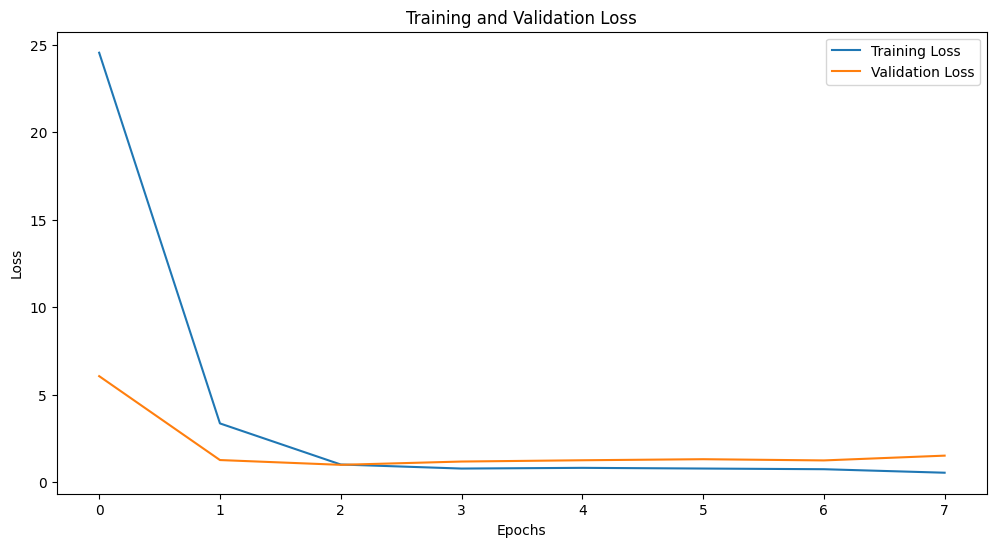

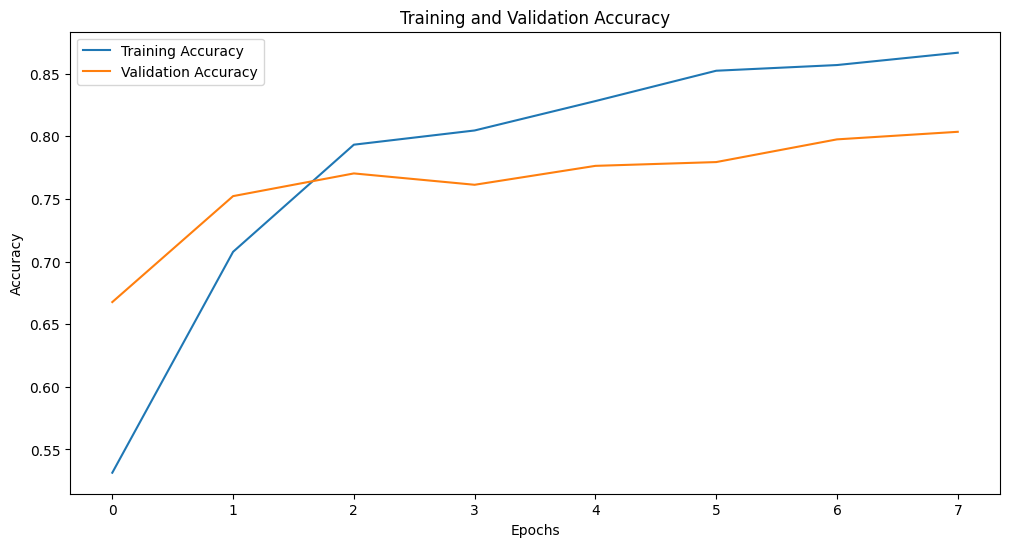

11/11 [==============================] - 2s 163ms/step


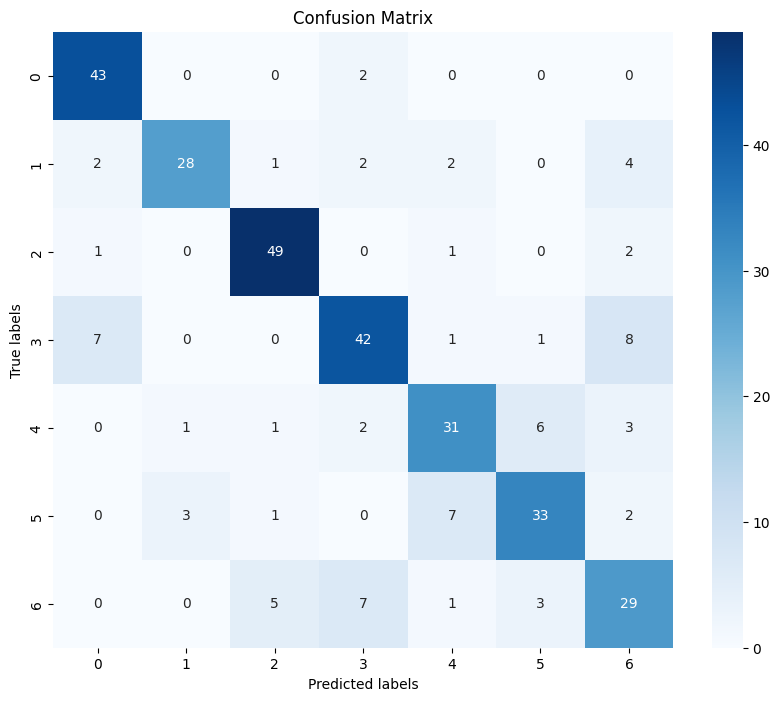

In [23]:
plot_training_history(history_4)
pcm4 = plot_confusion_matrix(model_4, X_test, y_test)

# **I will create a function to check the classification report of my models**

In [24]:
def generate_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true_classes = np.argmax(y_test, axis=1)

    report = classification_report(y_true_classes, y_pred_classes)
    return report

report_model_4 = generate_classification_report(model_4, X_test, y_test)
print("Classification Report for Model 4:\n", report_model_4)

11/11 [==============================] - 2s 168ms/step
Classification Report for Model 4:
               precision    recall  f1-score   support

           0       0.81      0.96      0.88        45
           1       0.88      0.72      0.79        39
           2       0.86      0.92      0.89        53
           3       0.76      0.71      0.74        59
           4       0.72      0.70      0.71        44
           5       0.77      0.72      0.74        46
           6       0.60      0.64      0.62        45

    accuracy                           0.77       331
   macro avg       0.77      0.77      0.77       331
weighted avg       0.77      0.77      0.77       331



# **Fifth Model**

In [27]:
from tensorflow.keras.applications import VGG19

base_model_2 = VGG19(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

for layer in base_model_2.layers:
    layer.trainable = False

model_5 = Sequential()
model_5.add(base_model)
model_5.add(Flatten())
model_5.add(Dense(512, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(7, activation='softmax'))

model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_5 = ModelCheckpoint("model_5_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_5 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_5 = model_5.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[checkpoint_5, early_stopping_5])

test_loss_5, test_accuracy_5 = model_5.evaluate(X_test, y_test)
print("Test Accuracy for Model 5:", test_accuracy_5)

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 31.5450 - accuracy: 0.4921
Epoch 1: val_accuracy improved from -inf to 0.69486, saving model to model_5_best.h5
42/42 [==============================] - 11s 236ms/step - loss: 31.5450 - accuracy: 0.4921 - val_loss: 3.9126 - val_accuracy: 0.6949
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 1.9408 - accuracy: 0.7214
Epoch 2: val_accuracy improved from 0.69486 to 0.70997, saving model to model_5_best.h5
42/42 [==============================] - 9s 219ms/step - loss: 1.9408 - accuracy: 0.7214 - val_loss: 1.6937 - val_accuracy: 0.7100
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.9042 - accuracy: 0.7676
Epoch 3: val_accuracy improved from 0.70997 to 0.76737, saving model to model_5_best.h5
42/42 [==============================] - 9s 222ms/step - loss: 0.9042 - accuracy: 0.7676 - val_loss: 1.3548 - val_accuracy: 0.7674
Epoch 4/100
42/42 [==============================] - ETA: 

In [29]:
report_model_5 = generate_classification_report(model_5, X_test, y_test)
print("Classification Report for Model 5:\n", report_model_5)

11/11 [==============================] - 2s 143ms/step
Classification Report for Model 5:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86        45
           1       0.89      0.79      0.84        39
           2       1.00      0.96      0.98        53
           3       0.74      0.78      0.76        59
           4       0.69      0.82      0.75        44
           5       0.71      0.74      0.72        46
           6       0.78      0.64      0.71        45

    accuracy                           0.80       331
   macro avg       0.81      0.80      0.80       331
weighted avg       0.81      0.80      0.80       331



In [31]:
print(labels)

['tomato__K', 'tomato__healthy', 'tomato__MIT', 'tomato__LM', 'tomato__healthy', 'tomato__LM', 'tomato__JAS_MIT', 'tomato__JAS_MIT', 'tomato__N', 'tomato__healthy', 'tomato__JAS_MIT', 'tomato__N_K', 'tomato__LM', 'tomato__N_K', 'tomato__K', 'tomato__N_K', 'tomato__K', 'tomato__LM', 'tomato__N', 'tomato__JAS_MIT', 'tomato__K', 'tomato__K', 'tomato__N', 'tomato__K', 'tomato__JAS_MIT', 'tomato__K', 'tomato__JAS_MIT', 'tomato__MIT', 'tomato__JAS_MIT', 'tomato__healthy', 'tomato__K', 'tomato__N', 'tomato__N', 'tomato__N', 'tomato__JAS_MIT', 'tomato__N', 'tomato__N_K', 'tomato__K', 'tomato__LM', 'tomato__healthy', 'tomato__LM', 'tomato__N', 'tomato__healthy', 'tomato__MIT', 'tomato__healthy', 'tomato__healthy', 'tomato__N_K', 'tomato__LM', 'tomato__K', 'tomato__N', 'tomato__N', 'tomato__JAS_MIT', 'tomato__healthy', 'tomato__LM', 'tomato__N', 'tomato__N', 'tomato__JAS_MIT', 'tomato__healthy', 'tomato__LM', 'tomato__LM', 'tomato__MIT', 'tomato__N', 'tomato__N', 'tomato__LM', 'tomato__LM', 'tom

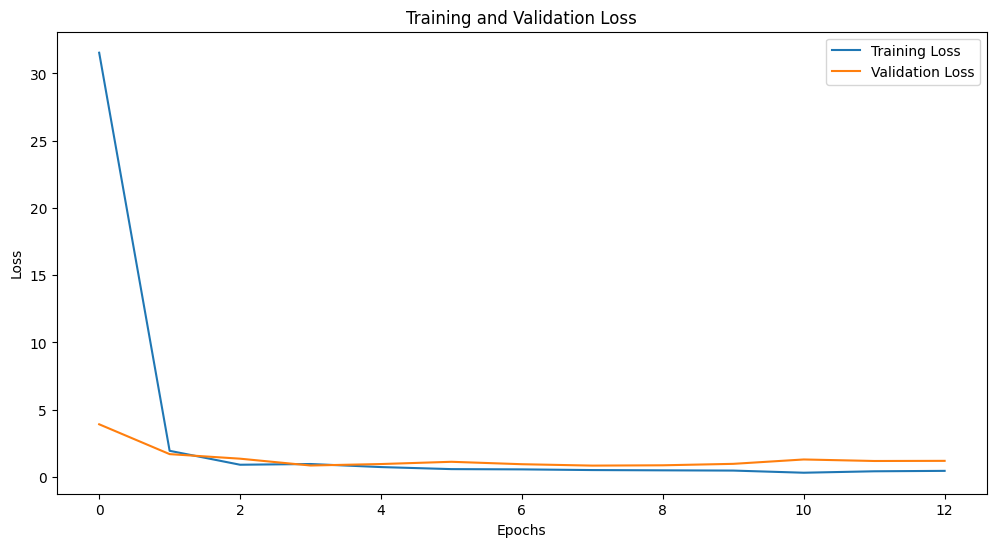

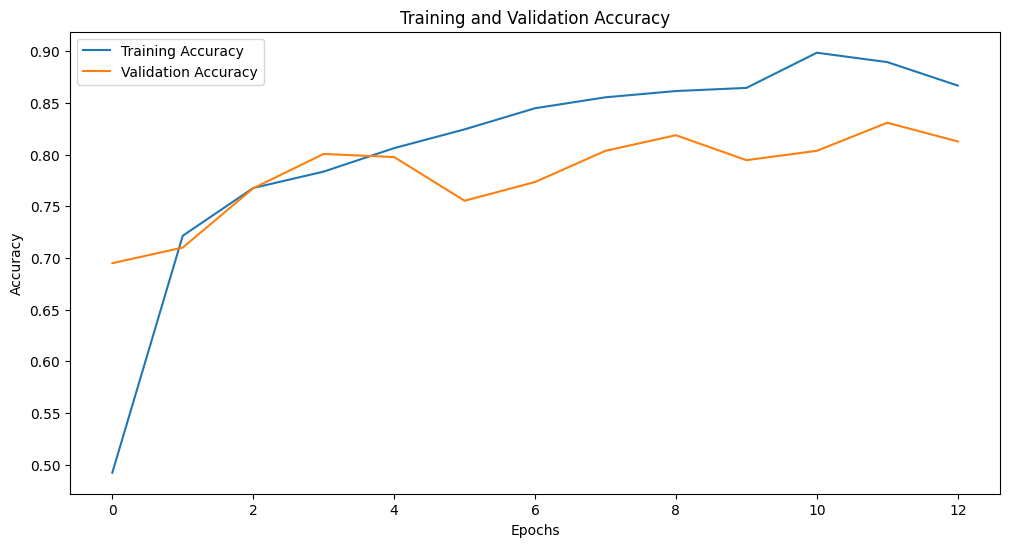

In [47]:
plot_training_history(history_5)

11/11 [==============================] - 1s 143ms/step


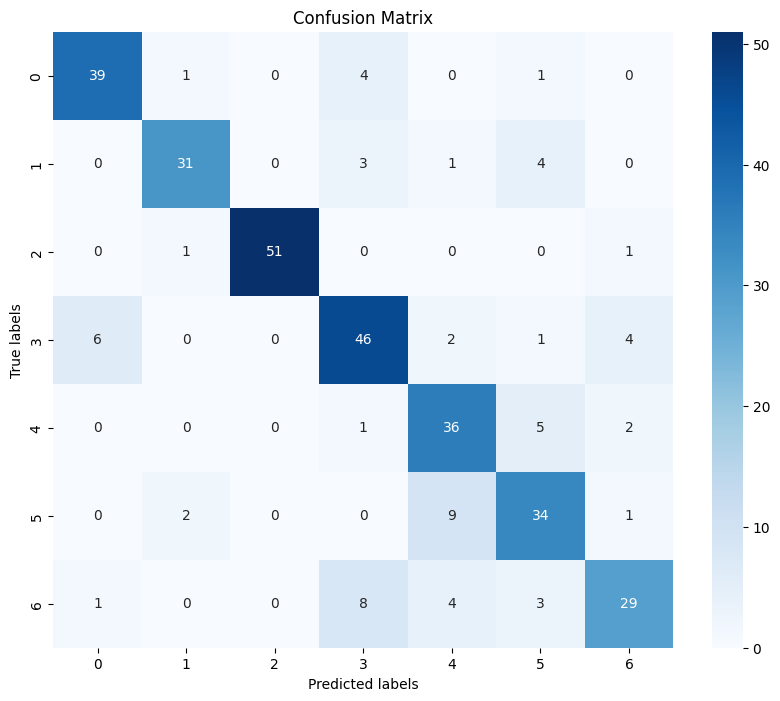

In [30]:
pcm5 = plot_confusion_matrix(model_5, X_test, y_test)

# **I decided to create slightly modified functions to create, save and download Model 5's confusion matrix as well as history**

In [144]:
def save_and_download_confusion_matrix(model, X_test, y_test, filename):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)

    label_encoder = LabelEncoder()
    label_encoder.fit(y_test)
    class_labels = label_encoder.inverse_transform(np.unique(y_test))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_model5.png')
    from google.colab import files
    files.download('confusion_matrix_model5.png')

11/11 [==============================] - 2s 165ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

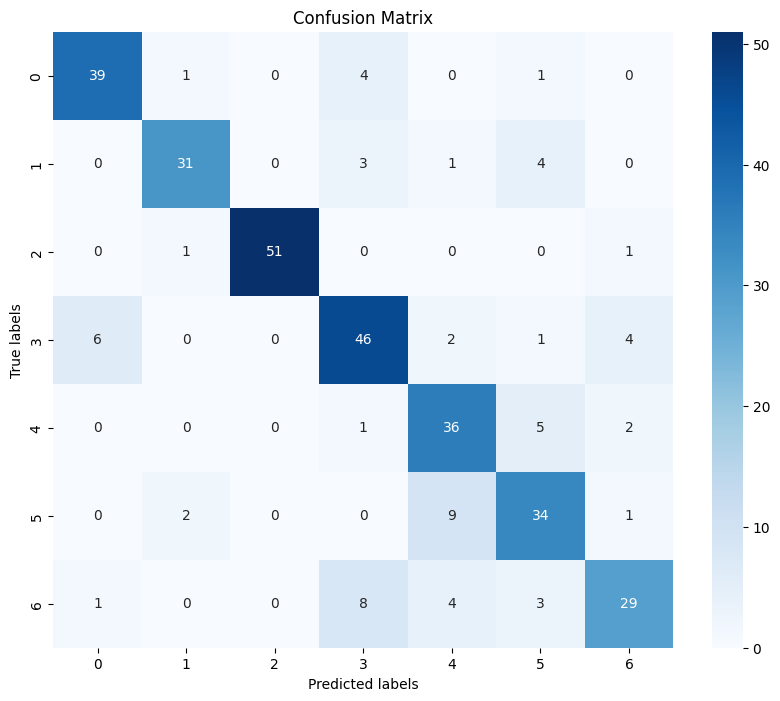

In [145]:
save_and_download_confusion_matrix(model_5, X_test, y_test,'confusion_matrix_model5.png' )

In [55]:
def save_and_download_training_history(history, filename_prefix):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig(f'{filename_prefix}_loss.png')
    from google.colab import files
    files.download(f'{filename_prefix}_loss.png')

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig(f'{filename_prefix}_accuracy.png')
    files.download(f'{filename_prefix}_accuracy.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

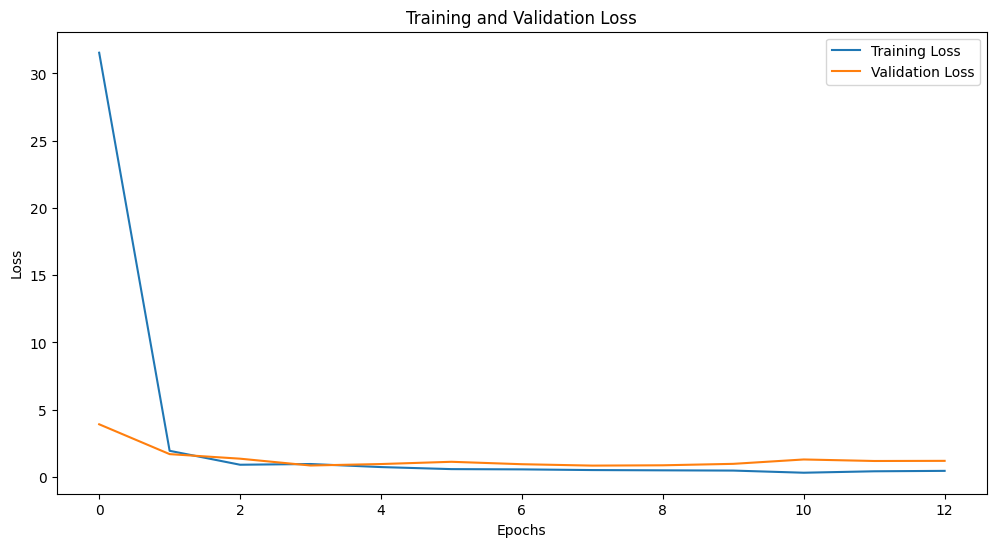

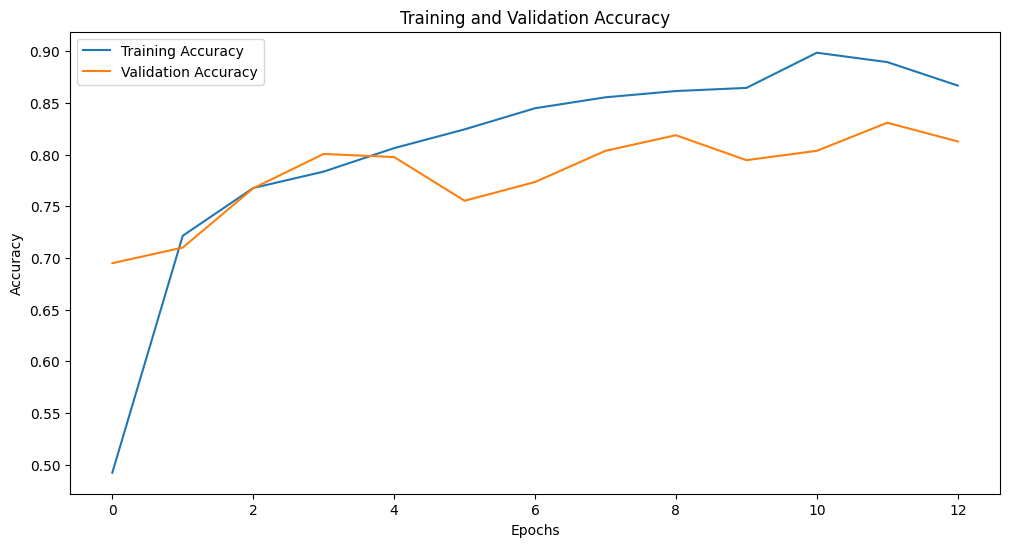

In [56]:
save_and_download_training_history(history_5, 'model5_history.png')

# **Sixth Model**

In [37]:
base_model_3 = VGG19(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

for layer in base_model_3.layers:
    layer.trainable = False

model_6 = Sequential()
model_6.add(base_model_3)
model_6.add(Flatten())
model_6.add(Dense(512, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(7, activation='softmax'))

model_6.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

batch_size = 32
train_datagen_6 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen_6 = ImageDataGenerator(rescale=1./255)

train_generator_6 = train_datagen_6.flow(X_train, y_train, batch_size=batch_size)
validation_generator_6 = validation_datagen_6.flow(X_test, y_test, batch_size=batch_size)

checkpoint_6 = ModelCheckpoint("model_6_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_6 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_6 = model_6.fit(
    train_generator_6,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=100,
    validation_data=validation_generator_6,
    validation_steps=len(X_test) // batch_size,
    callbacks=[checkpoint_6, early_stopping_6])

test_loss_6, test_accuracy_6 = model_6.evaluate(X_test, y_test)
print("Test Accuracy for Model 6:", test_accuracy_6)


Epoch 1/100
41/41 [==============================] - ETA: 0s - loss: 4.1889 - accuracy: 0.2552
Epoch 1: val_accuracy improved from -inf to 0.47188, saving model to model_6_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 21s 479ms/step - loss: 4.1889 - accuracy: 0.2552 - val_loss: 1.5808 - val_accuracy: 0.4719
Epoch 2/100
41/41 [==============================] - ETA: 0s - loss: 1.7075 - accuracy: 0.2956
Epoch 2: val_accuracy did not improve from 0.47188
41/41 [==============================] - 20s 478ms/step - loss: 1.7075 - accuracy: 0.2956 - val_loss: 1.4427 - val_accuracy: 0.4719
Epoch 3/100
41/41 [==============================] - ETA: 0s - loss: 1.6541 - accuracy: 0.3437
Epoch 3: val_accuracy did not improve from 0.47188
41/41 [==============================] - 19s 450ms/step - loss: 1.6541 - accuracy: 0.3437 - val_loss: 1.4770 - val_accuracy: 0.4469
Epoch 4/100
41/41 [==============================] - ETA: 0s - loss: 1.6376 - accuracy: 0.3204
Epoch 4: val_accuracy did not improve from 0.47188
41/41 [==============================] - 19s 468ms/step - loss: 1.6376 - accuracy: 0.3204 - val_loss: 1.3792 - val_accuracy: 0.4594
Epoch 5/100
41/41 [===============

In [38]:
report_model_6 = generate_classification_report(model_6, X_test, y_test)
print("Classification Report for Model 5:\n", report_model_6)

11/11 [==============================] - 2s 183ms/step
Classification Report for Model 5:
               precision    recall  f1-score   support

           0       0.44      0.62      0.51        45
           1       0.23      0.62      0.34        39
           2       0.75      0.62      0.68        53
           3       0.00      0.00      0.00        59
           4       0.29      0.75      0.42        44
           5       0.00      0.00      0.00        46
           6       0.00      0.00      0.00        45

    accuracy                           0.36       331
   macro avg       0.24      0.37      0.28       331
weighted avg       0.25      0.36      0.27       331



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Seventh Model**

In [39]:
base_model_4 = VGG19(weights='imagenet', include_top=False, input_shape=(image_width, image_height, 3))

for layer in base_model_4.layers:
    layer.trainable = False

model_7 = Sequential()
model_7.add(base_model_4)
model_7.add(Flatten())
model_7.add(Dense(512, activation='relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(7, activation='softmax'))

model_7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_datagen_7 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen_7 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')

checkpoint_7 = ModelCheckpoint("model_7_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_7 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history_7 = model_7.fit(
    train_datagen_7.flow(X_train, y_train, batch_size=32),
    epochs=100,
    steps_per_epoch=len(X_train) / 32,
    validation_data=validation_datagen_7.flow(X_test, y_test, batch_size=32),
    validation_steps=len(X_test) / 32,
    callbacks=[checkpoint_7, early_stopping_7])

test_loss_7, test_accuracy_7 = model_7.evaluate(X_test, y_test)
print("Test Accuracy for Model 7:", test_accuracy_7)

Epoch 1/100
42/41 [==============================] - ETA: 0s - loss: 4.5843 - accuracy: 0.2475
Epoch 1: val_accuracy improved from -inf to 0.32628, saving model to model_7_best.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


41/41 [==============================] - 24s 553ms/step - loss: 4.5843 - accuracy: 0.2475 - val_loss: 1.7138 - val_accuracy: 0.3263
Epoch 2/100
42/41 [==============================] - ETA: 0s - loss: 1.7770 - accuracy: 0.2831
Epoch 2: val_accuracy improved from 0.32628 to 0.36254, saving model to model_7_best.h5
41/41 [==============================] - 23s 547ms/step - loss: 1.7770 - accuracy: 0.2831 - val_loss: 1.6666 - val_accuracy: 0.3625
Epoch 3/100
42/41 [==============================] - ETA: 0s - loss: 1.6644 - accuracy: 0.3210
Epoch 3: val_accuracy improved from 0.36254 to 0.37160, saving model to model_7_best.h5
41/41 [==============================] - 23s 550ms/step - loss: 1.6644 - accuracy: 0.3210 - val_loss: 1.5931 - val_accuracy: 0.3716
Epoch 4/100
42/41 [==============================] - ETA: 0s - loss: 1.6186 - accuracy: 0.3437
Epoch 4: val_accuracy improved from 0.37160 to 0.45015, saving model to model_7_best.h5
41/41 [==============================] - 23s 555ms/step

# **Eight Model**

In [40]:
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(512, activation='relu'))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(7, activation='softmax'))

model_cnn2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


train_datagen_8 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator_8 = train_datagen_8.flow(X_train, y_train, batch_size=20)

validation_datagen_8 = ImageDataGenerator(rescale=1./255)
validation_generator_8 = validation_datagen_8.flow(X_test, y_test, batch_size=20)

checkpoint_8 = ModelCheckpoint("model_8_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_8 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history8 = model_cnn2.fit(
    train_generator_8,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=300,
    validation_data=validation_generator_8,
    validation_steps=len(X_test) // batch_size,
    callbacks=[checkpoint_8, early_stopping_8])


test_loss_7, test_accuracy_7 = model_cnn2.evaluate(X_test, y_test)
print("Test Accuracy for model_cnn2:", test_accuracy_7)

Epoch 1/300
41/41 [==============================] - ETA: 0s - loss: 5.4986 - accuracy: 0.1439
Epoch 1: val_accuracy improved from -inf to 0.18000, saving model to model_8_best.h5
41/41 [==============================] - 16s 308ms/step - loss: 5.4986 - accuracy: 0.1439 - val_loss: 1.9444 - val_accuracy: 0.1800
Epoch 2/300
41/41 [==============================] - ETA: 0s - loss: 1.9461 - accuracy: 0.1336
Epoch 2: val_accuracy improved from 0.18000 to 0.18500, saving model to model_8_best.h5
41/41 [==============================] - 12s 302ms/step - loss: 1.9461 - accuracy: 0.1336 - val_loss: 1.9453 - val_accuracy: 0.1850
Epoch 3/300
41/41 [==============================] - ETA: 0s - loss: 1.9465 - accuracy: 0.1311
Epoch 3: val_accuracy improved from 0.18500 to 0.19000, saving model to model_8_best.h5
41/41 [==============================] - 12s 297ms/step - loss: 1.9465 - accuracy: 0.1311 - val_loss: 1.9460 - val_accuracy: 0.1900
Epoch 4/300
40/41 [============================>.] - ETA: 

# **Ninth Model**

In [41]:
model_cnn9 = Sequential()
model_cnn9.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 3)))
model_cnn9.add(BatchNormalization())
model_cnn9.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn9.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn9.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn9.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn9.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn9.add(Flatten())
model_cnn9.add(Dense(512, activation='relu'))
model_cnn9.add(Dropout(0.5))
model_cnn9.add(Dense(7, activation='softmax'))

model_cnn9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

checkpoint_9 = ModelCheckpoint("model_cnn9_best.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping_9 = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

history9 = model_cnn9.fit(X_train, y_train, epochs=100,
                        batch_size=32, validation_data=(X_test, y_test),
                        callbacks=[checkpoint_9, early_stopping_9])

test_loss_9, test_accuracy_9 = model_cnn9.evaluate(X_test, y_test)
print("Test Accuracy for model_cnn9:", test_accuracy_9)

Epoch 1/100
41/42 [============================>.] - ETA: 0s - loss: 8.8130 - accuracy: 0.1951
Epoch 1: val_accuracy improved from -inf to 0.13293, saving model to model_cnn9_best.h5
42/42 [==============================] - 8s 143ms/step - loss: 8.7646 - accuracy: 0.1968 - val_loss: 5.6305 - val_accuracy: 0.1329
Epoch 2/100
41/42 [============================>.] - ETA: 0s - loss: 1.5528 - accuracy: 0.4527
Epoch 2: val_accuracy improved from 0.13293 to 0.48640, saving model to model_cnn9_best.h5
42/42 [==============================] - 6s 136ms/step - loss: 1.5527 - accuracy: 0.4512 - val_loss: 1.4116 - val_accuracy: 0.4864
Epoch 3/100
41/42 [============================>.] - ETA: 0s - loss: 0.9772 - accuracy: 0.6608
Epoch 3: val_accuracy improved from 0.48640 to 0.62840, saving model to model_cnn9_best.h5
42/42 [==============================] - 6s 133ms/step - loss: 0.9737 - accuracy: 0.6624 - val_loss: 1.1188 - val_accuracy: 0.6284
Epoch 4/100
41/42 [============================>.] -

In [44]:
report_model_cnn9 = generate_classification_report(model_cnn9, X_test, y_test)
print("Classification Report for Model_cnn9:\n", report_model_cnn9)

11/11 [==============================] - 0s 23ms/step
Classification Report for Model_cnn9:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84        45
           1       0.60      0.77      0.67        39
           2       0.73      0.87      0.79        53
           3       0.70      0.66      0.68        59
           4       0.69      0.55      0.61        44
           5       0.85      0.76      0.80        46
           6       0.50      0.40      0.44        45

    accuracy                           0.70       331
   macro avg       0.70      0.70      0.69       331
weighted avg       0.70      0.70      0.69       331



11/11 [==============================] - 0s 21ms/step


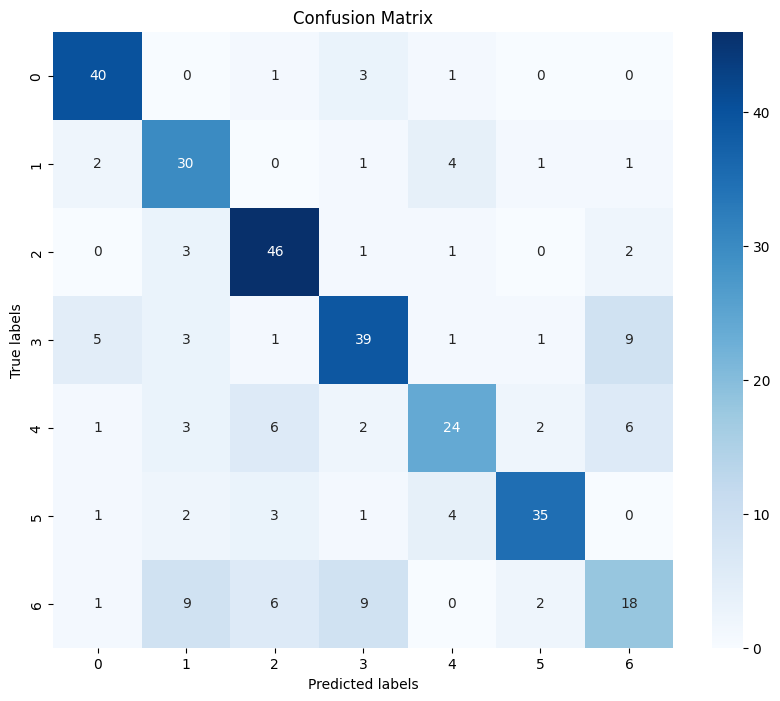

In [45]:
pcm9 = plot_confusion_matrix(model_cnn9, X_test, y_test)

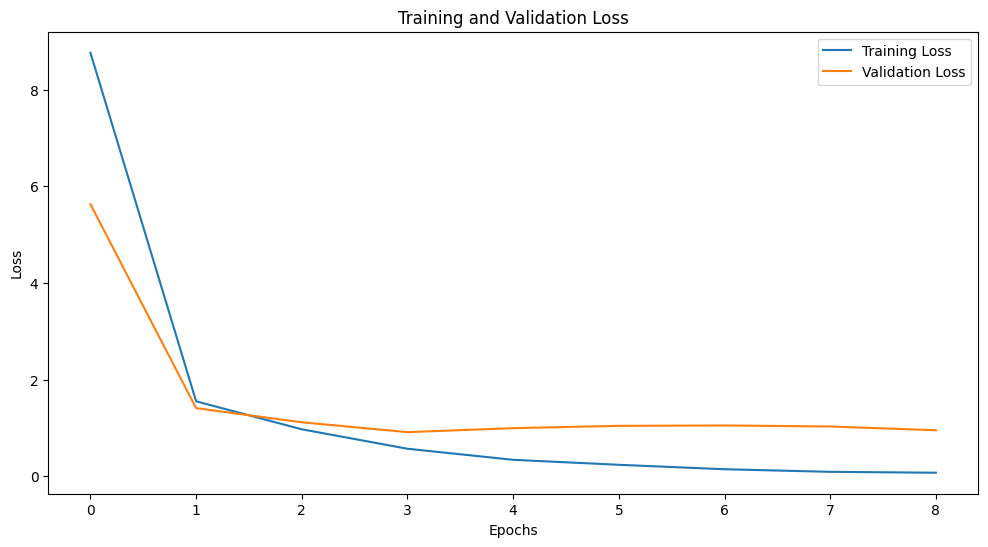

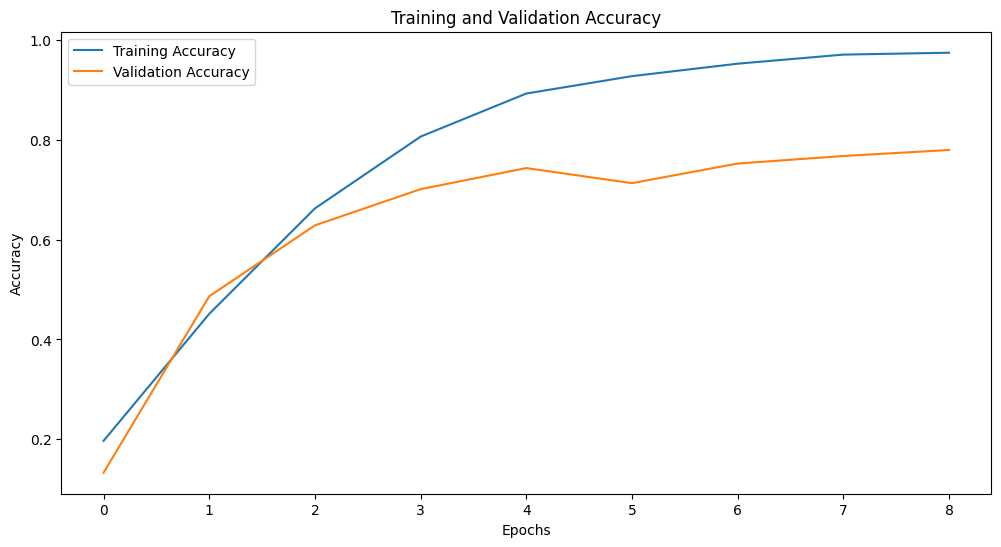

In [46]:
plot_training_history(history9)

# **Now that I have a best performing model I'm satisfied with, I will save the functions and that model in the corresponding pickle files ✅**

In [33]:
%%writefile my_functions.py
def load_and_resize_images(images_path, target_size=(256, 256)):
    images = []
    labels = []

    for label in os.listdir(images_path):
        label_path = os.path.join(images_path, label)
        if os.path.isdir(label_path):
            for image_name in os.listdir(label_path):
                image_path = os.path.join(label_path, image_name)
                if os.path.isfile(image_path):
                    image = Image.open(image_path).resize(target_size)
                    images.append(np.array(image))
                    labels.append(label)

    return images, labels

def check_class_distribution(labels):
    class_counts = {}
    for label in labels:
        class_counts[label] = class_counts.get(label, 0) + 1
    return class_counts

  def apply_smote(images, labels, target_samples=200):

    images = np.array(images)
    labels = np.array(labels)

    num_samples = images.shape[0]
    num_features = np.prod(images.shape[1:])
    images_2d = images.reshape(num_samples, num_features)

    label_to_int = {label: i for i, label in enumerate(np.unique(labels))}
    labels_int = np.array([label_to_int[label] for label in labels])

    smote = SMOTE(sampling_strategy={label_to_int[label]: target_samples for label in label_to_int.keys()}, random_state=42)
    images_resampled_2d, labels_resampled = smote.fit_resample(images_2d, labels_int)

    images_resampled = images_resampled_2d.reshape(-1, *images.shape[1:])

    int_to_label = {i: label for label, i in label_to_int.items()}
    labels_resampled = [int_to_label[i] for i in labels_resampled]

    images_resampled, labels_resampled = shuffle(images_resampled, labels_resampled, random_state=42)

    return images_resampled, labels_resampled

def preprocess_data(images, labels):

    images_array = np.array(images)

    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)
    labels_encoded = labels_encoded.reshape(len(labels_encoded), 1)
    onehot_encoder = OneHotEncoder(sparse=False)
    labels_onehot = onehot_encoder.fit_transform(labels_encoded)

    return images_array, labels_onehot

def plot_training_history(history):

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    cm = confusion_matrix(y_test, y_pred_classes)

    label_encoder = LabelEncoder()
    label_encoder.fit(y_test)
    class_labels = label_encoder.inverse_transform(np.unique(y_test))

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def generate_classification_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true_classes = np.argmax(y_test, axis=1)

    report = classification_report(y_true_classes, y_pred_classes)
    return report

Writing my_functions.py


In [42]:
files.download('my_functions.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Now to download the file in my Drive**

In [34]:
drive_destination_path = '/content/drive/MyDrive/Ironhack proyect/my_functions.py'
shutil.copy("my_functions.py", drive_destination_path)

'/content/drive/MyDrive/Ironhack proyect/my_functions.py'

In [43]:
'''functions_to_store = [load_and_resize_images, check_class_distribution, apply_smote, preprocess_data, plot_training_history,
                      plot_confusion_matrix, generate_classification_report]

for function in functions_to_store:
    with open(f"{function.__name__}.pickle", "wb") as f:
        pickle.dump(function, f)

for function in functions_to_store:
    files.download(f"{function.__name__}.pickle")'''

'functions_to_store = [load_and_resize_images, check_class_distribution, apply_smote, preprocess_data, plot_training_history, \n                      plot_confusion_matrix, generate_classification_report]\n\nfor function in functions_to_store:\n    with open(f"{function.__name__}.pickle", "wb") as f:\n        pickle.dump(function, f)\n\nfor function in functions_to_store:\n    files.download(f"{function.__name__}.pickle")'

In [28]:
best_model = load_model("model_5_best.h5")
dump(best_model, "tomato_plant_diagnoser.pkl")

files.download('tomato_plant_diagnoser.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Also, downloading the model into the Drive**

In [36]:
drive_destination_path = '/content/drive/MyDrive/Ironhack proyect/tomato_plant_diagnoser.pkl'
shutil.copy("tomato_plant_diagnoser.pkl", drive_destination_path)

'/content/drive/MyDrive/Ironhack proyect/tomato_plant_diagnoser.pkl'

# **Now I will save my notebook on my Drive and my PC**

In [60]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!cp "/content/drive/MyDrive/Colab Notebooks/Proyectomate.ipynb" "/content/drive/My Drive/Ironhack proyect/"


In [66]:
files.download('/content/drive/MyDrive/Ironhack proyect/Proyectomate.ipynb')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **I used this little trick to avoid Google Colab from disconnecting**

In [90]:
import time

# Run an infinite loop to keep the session alive
while True:
    time.sleep(120)  # Sleep for 60 seconds

KeyboardInterrupt: 

In [21]:
!pip freeze > /content/requirements.txt

In [22]:
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Now I will try my model**

In [123]:
def predict_new_image_class(model_path, label_encoder_path, target_size):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)

    with open(label_encoder_path, 'rb') as f:
        label_encoder = pickle.load(f)

    image_path = input("Enter the path to the image file: ")

    image = Image.open(image_path)
    image = image.resize(target_size)
    image_array = np.array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)



    predicted_probabilities = model.predict(image_array)
    predicted_class_index = np.argmax(predicted_probabilities)
    class_label = label_encoder.inverse_transform([predicted_class_index])[0]

    return class_label

In [141]:
model_path = "/content/drive/MyDrive/Ironhack proyect/tomato_plant_diagnoser.pkl"
label_encoder_path = "/content/drive/MyDrive/Ironhack proyect/label_encoder.pkl"
target_size = (256, 256)
predicted_class = predict_new_image_class(model_path, label_encoder_path, (256,256))
print("Predicted class:", predicted_class)

Enter the path to the image file: /content/drive/MyDrive/Ironhack proyect/tomato__N_K/tomato__N_K (31).JPG
1/1 [==============================] - 0s 134ms/step
Predicted class: tomato__N_K


In [122]:

print(label_encoder.classes_)

['tomato__JAS_MIT' 'tomato__K' 'tomato__LM' 'tomato__MIT' 'tomato__N'
 'tomato__N_K' 'tomato__healthy']
